# Text Classification With Transformers

Lots of datasets available on the huggingface plateform / hub

In [1]:
from datasets import list_datasets

all_datasets = list_datasets()

print(f"there are {len(all_datasets)} datasets available on huggingface")
print(f"the first 10 are {all_datasets[:10]}")

/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/cv/rf4bgk9d1sqgbjbk5ydbt4740000gn/T/ipykernel_30903/1802018648.py:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


there are 163087 datasets available on huggingface
the first 10 are ['amirveyseh/acronym_identification', 'ade-benchmark-corpus/ade_corpus_v2', 'UCLNLP/adversarial_qa', 'Yale-LILY/aeslc', 'nwu-ctext/afrikaans_ner_corpus', 'fancyzhx/ag_news', 'allenai/ai2_arc', 'google/air_dialogue', 'komari6/ajgt_twitter_ar', 'legacy-datasets/allegro_reviews']


Let's chose the emotions dataset

In [2]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Transform hugggingFace dataset into Pandas df

In [3]:
import pandas as pd

emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


let's turn the label ints into strings

In [4]:
def label_int2str(row):
    return emotions["train"].features['label'].int2str(row)

df['label_name'] =  df['label'].apply(label_int2str)

df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Let's dive into the data

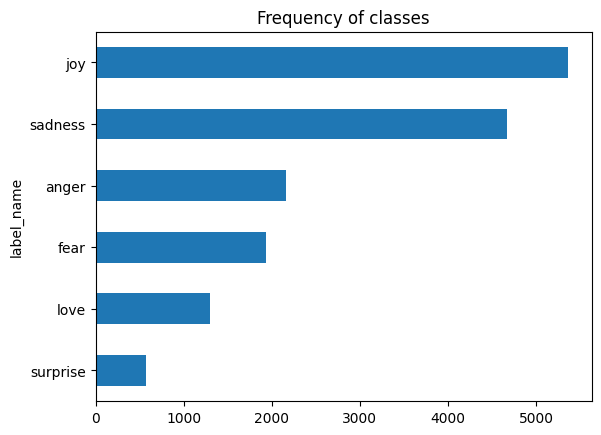

In [5]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

The classes are imbalanced, some are 5 to 10 times more frequent that others

Transformers have a maximum input sequence length, we need to see how long the text examples are in our data to chose our models appropriately

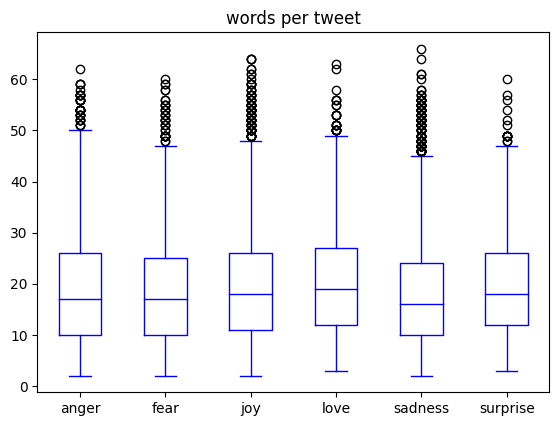

In [6]:
df['words per tweet'] = df['text'].str.split().apply(len)
df.boxplot("words per tweet", by="label_name", grid=False, showfliers=True, color="blue")
plt.suptitle("")
plt.xlabel("")
plt.show()

The tweet lenght don't go far over 60 words. A model like distillBERT can have up to 512 tokens in an input sequence so we are good here.
We can now reset the dataset to its original format:

In [7]:
emotions.reset_format()

## Tokenization

In [8]:
from transformers import AutoTokenizer

model_cpk = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_cpk)

Let's see how the tokenizer works

In [9]:
text = "Slow Morning House Music Mix - Chill Funky Breakfast Playlist | Deep Relaxing Brunch Terrace DJ Set."

encoded_text = tokenizer(text)
print(encoded_text)

tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)
print(tokenizer.convert_tokens_to_string(tokens))

print("Vocab size: ", tokenizer.vocab_size)
print("max length of inputs: ", tokenizer.model_max_length)
print("Name of the fields that the model expects: ", tokenizer.model_input_names)

{'input_ids': [101, 4030, 2851, 2160, 2189, 4666, 1011, 10720, 24151, 6350, 2377, 9863, 1064, 2784, 19613, 7987, 4609, 2818, 11134, 6520, 2275, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'slow', 'morning', 'house', 'music', 'mix', '-', 'chill', 'funky', 'breakfast', 'play', '##list', '|', 'deep', 'relaxing', 'br', '##un', '##ch', 'terrace', 'dj', 'set', '.', '[SEP]']
[CLS] slow morning house music mix - chill funky breakfast playlist | deep relaxing brunch terrace dj set. [SEP]
Vocab size:  30522
max length of inputs:  512
Name of the fields that the model expects:  ['input_ids', 'attention_mask']


Notice how the tokenizer broke down the work "brunch" in 3: br ##un ##ch as it did not recognize it. Leaving the model to learn it.

#### Tokenize the whole dataset

In [10]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

print(emotions_encoded['train'].column_names)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map: 100%|██████████| 2000/2000 [00:00<00:00, 51393.86 examples/s]

['text', 'label', 'input_ids', 'attention_mask']


## Training a Text Classifier

2 options:
 - Feature extraction: freeze the weights of the pre-trained transformer model and use the hidden states as features to train a classifier on them. The classifier could be anything, logistic regression, random forest etc...

 - Fine-Tuning: we train the whole model end to end, so the weights of the pre-trained model will be modified. 

In [44]:
from transformers import AutoModel 
import torch


model_cpk = "distilbert-base-uncased"

device = torch.device("mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cpu")
print("device: ", device)
model = AutoModel.from_pretrained(model_cpk).to(device)

device:  mps


Let's extract the hidden states for all the examples in our dataset and add them as a new column in our dataframe. 

For classification problem, it's usual to take the hidden state of the starting token [CLS] as the hidden state of the whole sentence.

In [45]:
def extract_hidden_states(batch):
    # Place model inputs (input_ids and attention_masks) on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    # Extract last hidden states
    # no_grad prevent computation of the gradient. it saves memory.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token as a numpy array for the map function
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}    


# Convert our dataset to a tensor
emotions_encoded.set_format("torch", columns=['input_ids', "attention_mask", 'label'])

emotion_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

emotion_hidden['train'].column_names

Map: 100%|██████████| 2000/2000 [00:05<00:00, 388.62 examples/s]


['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [13]:
emotion_hidden['train'][0]['hidden_state']

tensor([-1.1675e-01,  9.8571e-02, -1.2963e-01, -9.5018e-02, -2.8083e-01,
        -1.3222e-01,  2.2748e-01,  2.3100e-01,  1.6752e-01, -2.4663e-01,
         2.1755e-02, -1.0200e-01, -1.8098e-01,  2.2351e-01,  2.0275e-01,
         1.1693e-01, -6.9545e-04,  1.2025e-01, -1.4259e-04, -6.0743e-02,
        -1.4382e-01, -3.1201e-01, -1.0877e-01,  1.1821e-01, -7.3939e-02,
         7.2635e-02,  2.1319e-01, -2.9570e-01,  1.0432e-01, -1.4980e-01,
         1.1913e-01,  1.3559e-01, -2.0512e-01,  7.9983e-02, -1.2340e-01,
         2.4995e-02,  1.1948e-02,  1.0090e-02,  1.3740e-01, -1.3440e-02,
        -1.1266e-01, -7.7647e-02, -1.3007e-01, -7.1688e-02,  8.5297e-02,
        -5.4750e-02, -2.1881e+00, -5.0468e-02, -3.2211e-01, -1.6244e-01,
         3.1700e-01, -1.9575e-01,  1.3216e-01,  3.7076e-01, -5.4104e-02,
         3.5674e-01, -1.9445e-01,  3.1695e-01, -2.2347e-02,  9.1785e-02,
         2.9930e-01,  2.1970e-01, -1.4083e-01, -7.3252e-03, -7.7053e-02,
         2.2294e-01, -8.2599e-02,  3.5193e-01, -1.1

#### Create a feature matrix for our classifier

In [14]:
import numpy as np

X_train = np.array(emotion_hidden['train']['hidden_state'])
X_valid = np.array(emotion_hidden['validation']['hidden_state'])
y_train = np.array(emotion_hidden['train']['label'])
y_valid = np.array(emotion_hidden['validation']['label'])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Visualazing the dataset

We can use the algo UMAP to reduce the dimension of our X_train feature matrix from 768 to 2, and plot the result per label. 

This will give us a good way to see if the classes are learnable (disctinct from each other).

UMAP works best when the features are scaled, so we'll use a MinMax scaler from Scikit Learn.

In [15]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [16]:
# scale features to [0,1]
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# Create a dataframe of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,4.636392,6.627836,0
1,-2.743189,6.162422,0
2,5.528084,3.074021,3
3,-2.214792,4.145278,2
4,-3.124166,4.383248,3


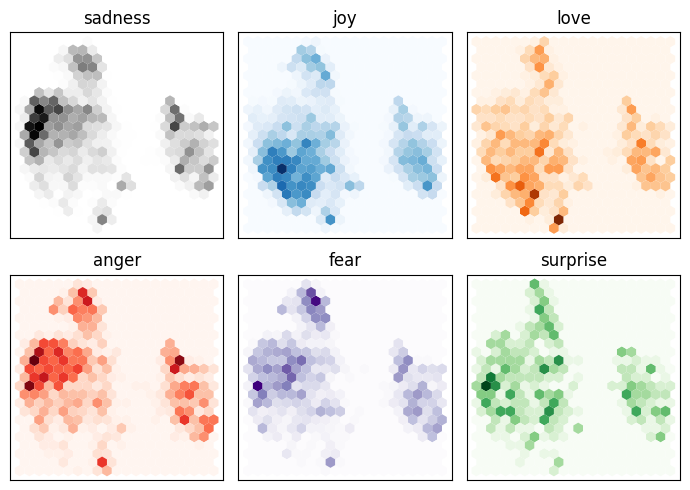

In [18]:
# Plot the results
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels,cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### Training a LogisticRegression

In [40]:
from sklearn.linear_model import LogisticRegression

# Increae max_iter to converge
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf_score =lr_clf.score(X_valid, y_valid)

# Compare with a Dummy Classifier that would always take the most frequent class
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf_score = dummy_clf.score(X_valid, y_valid)

print(f'Logistic Regression Score: {lr_clf_score}')
print(f'Dummy Classifier Score: {dummy_clf_score}')

Logistic Regression Score: 0.634
Dummy Classifier Score: 0.352


We can display the confusion matrix to dive in the results further

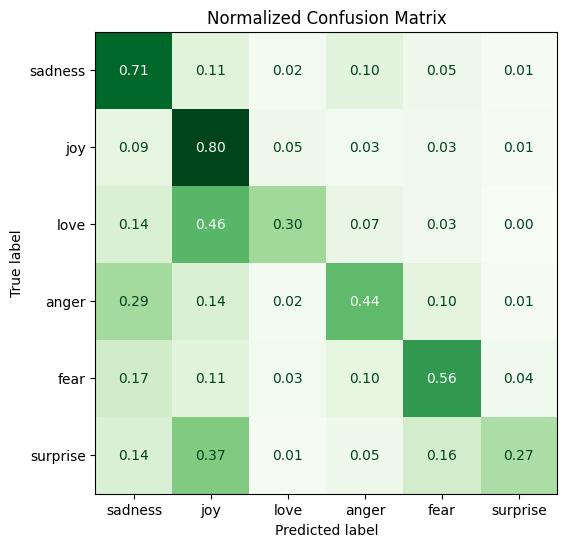

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Greens', values_format='.2f', ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)


In [42]:
print(f'f1 score: ', f1_score(y_true=y_valid, y_pred=y_preds, average='weighted'))

f1 score:  0.6218506977483459


## Fine Tuning Transformers

In [47]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model_cpk = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_cpk, num_labels=num_labels).to(device)


#### Defining Performance Metrics

In [48]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1_score':f1}



In [49]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_cpk}-finetuned-emotion'

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level='error'
                                  )

trainer = Trainer(model=model,
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'], 
                  eval_dataset=emotions_encoded['validation'], 
                  tokenizer=tokenizer)

trainer.train()

 50%|█████     | 250/500 [01:22<01:24,  2.97it/s]

{'loss': 0.8752, 'learning_rate': 1e-05, 'epoch': 1.0}


                                                 
 50%|█████     | 250/500 [01:25<01:24,  2.97it/s]

{'eval_loss': 0.33875584602355957, 'eval_accuracy': 0.9025, 'eval_f1_score': 0.9013417311338838, 'eval_runtime': 2.8486, 'eval_samples_per_second': 702.1, 'eval_steps_per_second': 11.234, 'epoch': 1.0}


100%|██████████| 500/500 [02:53<00:00,  2.83it/s]

{'loss': 0.2951, 'learning_rate': 0.0, 'epoch': 2.0}



100%|██████████| 500/500 [02:56<00:00,  2.83it/s]

{'eval_loss': 0.23645071685314178, 'eval_accuracy': 0.9265, 'eval_f1_score': 0.9266475684866127, 'eval_runtime': 2.2944, 'eval_samples_per_second': 871.694, 'eval_steps_per_second': 13.947, 'epoch': 2.0}
{'train_runtime': 176.5721, 'train_samples_per_second': 181.229, 'train_steps_per_second': 2.832, 'train_loss': 0.5851561126708984, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=0.5851561126708984, metrics={'train_runtime': 176.5721, 'train_samples_per_second': 181.229, 'train_steps_per_second': 2.832, 'train_loss': 0.5851561126708984, 'epoch': 2.0})

In [50]:
pred_output = trainer.predict(emotions_encoded['validation'])
pred_output.metrics

100%|██████████| 32/32 [00:02<00:00, 10.94it/s]


{'test_loss': 0.23645071685314178,
 'test_accuracy': 0.9265,
 'test_f1_score': 0.9266475684866127,
 'test_runtime': 3.0036,
 'test_samples_per_second': 665.872,
 'test_steps_per_second': 10.654}

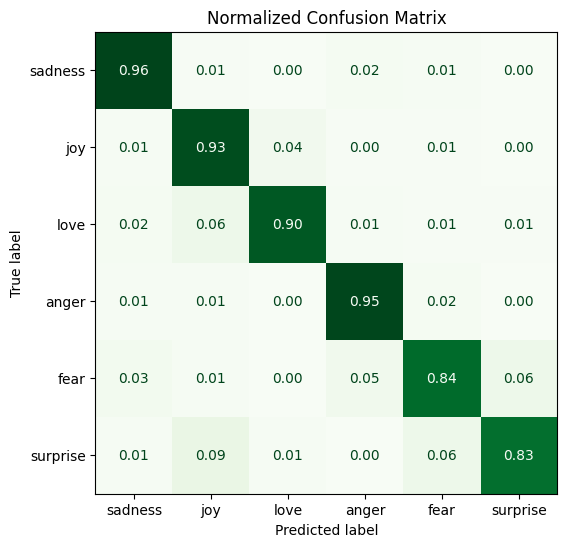

In [51]:
y_preds = np.argmax(pred_output.predictions, axis=1)
plot_confusion_matrix(y_preds=y_preds, y_true=y_valid, labels=labels)

## Error Analysis

Sort the predictions of the validation set by loss score (proxy for the model's confidence) to see where the model was wrong and why.

In [54]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensor on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_labels = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')
    # Place outputs on CPU for compatibility with other dataset columns
    return {'loss': loss.cpu().numpy(), 'predicted_label': pred_labels.cpu().numpy()}
    
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Compute loss values
emotions_encoded['validation'] = emotions_encoded['validation'].map(forward_pass_with_label, batched=True, batch_size=16)



Map: 100%|██████████| 2000/2000 [00:02<00:00, 702.87 examples/s]


Now let's revert back to a pandas dataframe

In [55]:
emotions_encoded.set_format('pandas')
cols = ['text', 'label', 'predicted_label', 'loss']
df_test = emotions_encoded['validation'][:][cols]
df_test['label'] =  df_test['label'].apply(label_int2str)
df_test['predicted_label'] =  df_test['predicted_label'].apply(label_int2str)

In [56]:
# Now we can have a look at the 10 data samples with the highest loss (aka where the model is the least confident):

df_test.sort_values('loss', ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.619539
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.263404
1950,i as representative of everything thats wrong ...,surprise,sadness,5.211047
1963,i called myself pro life and voted for perry w...,joy,sadness,5.113360
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.909760
1683,i had applied for a job and they had assured m...,anger,joy,4.897969
1111,im lazy my characters fall into categories of ...,joy,fear,4.883521
1801,i feel that he was being overshadowed by the s...,love,sadness,4.843360
1274,i am going to several holiday parties and i ca...,joy,sadness,4.788114
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.677634


In [57]:
# And now the samples where the model is the most confident
df_test.sort_values('loss', ascending=True).head(10)

,text,label,predicted_label,loss
369,i just need a few minutes to feel put upon and...,sadness,sadness,0.019105
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.019336
578,i got to christmas feeling positive about the ...,joy,joy,0.019474
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.019756
1513,i have also been getting back into my gym rout...,joy,joy,0.019912
1320,im feeling positive but its impossible to desc...,joy,joy,0.019914
69,i have no extra money im worried all of the ti...,sadness,sadness,0.019926
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.020098
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.020121
861,i am feeling awfully lonely today and i dont w...,sadness,sadness,0.020212


## Save the model on huggingface and reuse it later

In [61]:
trainer.push_to_hub("training done")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]
training_args.bin: 100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1kB/s]
pytorch_model.bin: 100%|██████████| 268M/268M [00:40<00:00, 6.57MB/s]
Upload 2 LFS files: 100%|██████████| 2/2 [00:41<00:00, 20.51s/it]


'https://huggingface.co/KlemPear/distilbert-base-uncased-finetuned-emotion/tree/main/'

In [62]:
from transformers import pipeline

model_id = f"KlemPear/{model_name}"
classifier = pipeline('text-classification', model=model_id)

config.json: 100%|██████████| 883/883 [00:00<00:00, 659kB/s]
pytorch_model.bin: 100%|██████████| 268M/268M [01:48<00:00, 2.47MB/s] 
tokenizer_config.json: 100%|██████████| 320/320 [00:00<00:00, 255kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 2.44MB/s]
tokenizer.json: 100%|██████████| 712k/712k [00:00<00:00, 5.74MB/s]
special_tokens_map.json: 100%|██████████| 125/125 [00:00<00:00, 124kB/s]


/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


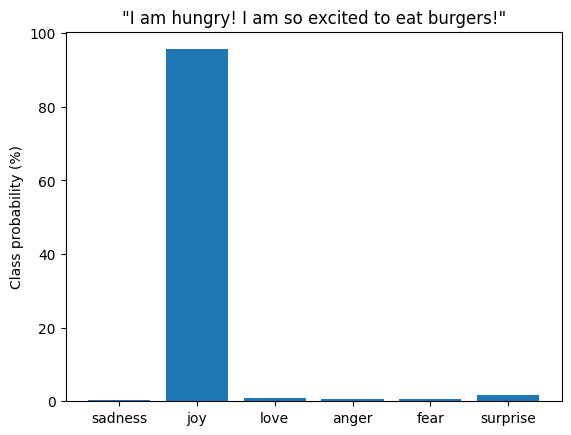

In [66]:
custom_text = 'I am hungry! I am so excited to eat burgers!'
preds = classifier(custom_text, return_all_scores=True)

preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df['score'], color='C0')
plt.title(f'"{custom_text}"')
plt.ylabel('Class probability (%)')
plt.show()